In [1]:
from scipy.io import loadmat
# import json
import pandas as pd
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 40
# plt.rcParams["figure.figsize"]  = (20, 25)
# from numpy import matlib
import seaborn as sns
import pingouin as pg
from gridfunctions import *
from itertools import compress
import scipy.stats as stats
import math
import os
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [9]:
df = pd.read_csv('data/df_exp3.csv')
df_part = pd.read_csv('data/df_exp3_part.csv')
df_probe = pd.read_csv('data/df_exp3_probe.csv')

t =  -3.453305679144847 p =  0.0006879586522763206


/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1650505712.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g2 = sns.swarmplot(data = temp, x = 'condition', y = 'resp_logsteps', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])


Text(47.972222222222214, 0.5, 'No. of Steps')

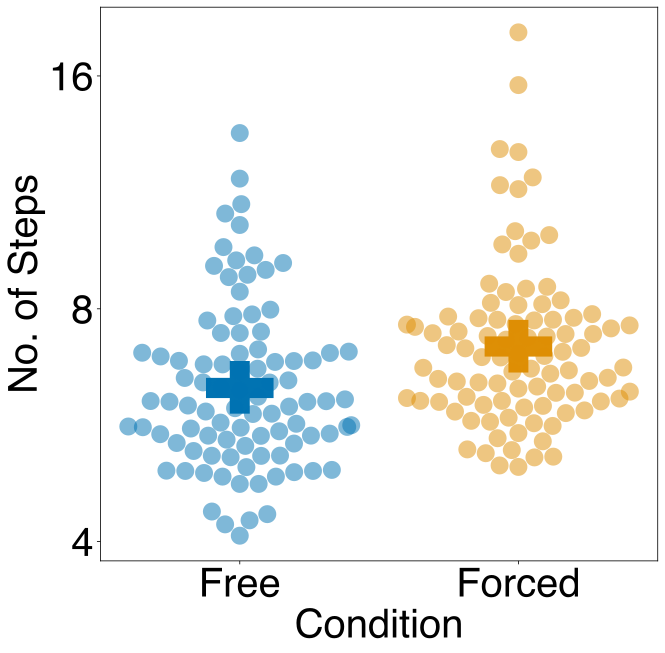

In [5]:
# %% performance free vs forced
        
temp = df[df['day'] == 2].groupby(['prolificid', 'condition'])['resp_logsteps'].mean().reset_index()

fig = plt.figure(figsize = (10,10))
g = sns.pointplot(data = temp, x = 'condition', y = 'resp_logsteps', linestyles = 'none', markers = '_', scale = 10, errwidth = 20, palette = 'colorblind', order = ['free', 'forced'])
plt.xlabel('Condition')
plt.ylabel('No. of Steps')
#xtick

plt.yticks([np.log(4), np.log(8), np.log(16), np.log(32)], ['4', '8', '16', '32'])

#add swarmplot
g2 = sns.swarmplot(data = temp, x = 'condition', y = 'resp_logsteps', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])

#independent samples t-test
t, p = stats.ttest_ind(temp[temp['condition'] == 'free']['resp_logsteps'], temp[temp['condition'] == 'forced']['resp_logsteps'])
print('t = ', t, 'p = ', p)
plt.xticks(np.linspace(0,1, 2), ['Free', 'Forced'])
plt.xlabel('Condition')
plt.ylabel('No. of Steps')

In [6]:
df_part_day1 = df[df['day'] == 1].groupby(['prolificid', 'condition'])[['resp_logsteps', 'resp_directionperc']].mean().reset_index()
# df_part = pd.concat([df_part_free, df_part_forced])

df_part_day1['sbsodscore'] = [df_part['sbsodscore'][df_part['prolificid'] == x].values[0] for x in df_part_day1['prolificid']]
df_part_day1['nsqscore'] = [df_part['nsqscore'][df_part['prolificid'] == x].values[0] for x in df_part_day1['prolificid']]

In [7]:
df_part_free = df_part[df_part['condition'] == 'free']
df_free = df[df['condition'] == 'free']

#per participant pca
prolificids = []
numparts = len(df_part_free['prolificid'])
explorefreq = np.zeros((numparts, 64))
avgdisttocentre = np.zeros(numparts)
avgvariance = np.zeros(numparts)
for num, i in enumerate(df_part_free['prolificid']):
    print(num)
    prolificids.append(i)
    clicks = np.zeros((8,8))
    disttocentre = []

    for j in df_free['trialno'][df_free['prolificid'] == i][df_free['day'] == 2]:
        xs = []
        ys = []
        variance = []
        explorexclicks = df_free['resp_explorexclicks'][df_free['day'] == 2][(df_free['prolificid'] == i) & (df_free['trialno'] == j)].values[0]
        exploreyclicks = df_free['resp_exploreyclicks'][df_free['day'] == 2][(df_free['prolificid'] == i) & (df_free['trialno'] == j)].values[0]
        # explorexclicks = list(map(int, list(explorexclicks)))
        #turn string into list of ints, each character is one int
        explorexclicks = list(map(int, list(str(explorexclicks))))[:-1]
        exploreyclicks = list(map(int, list(str(exploreyclicks))))[:-1]
        for (x,y) in zip(explorexclicks, exploreyclicks):
            # print(x,y)
            clicks[x-1,y-1] += 1
            disttocentre.append(np.sqrt((x-4.5)**2 + (y-4.5)**2))
            xs.append(x)
            ys.append(y)
        variance.append(np.var(xs) + np.var(ys))
    avgdisttocentre[num] = np.mean(disttocentre)
    avgvariance[num] = np.mean(variance)
    #flatten clicks
    print(clicks)
    clicks = clicks.flatten()
    # clicks = clicks / np.sum(clicks)
    explorefreq[num, :] = clicks

0
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 90.  3.  0.  0.  1. 86.  1.]
 [ 0.  2.  0.  1.  0.  1.  1.  1.]
 [ 0.  0.  0.  1.  1.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  2.  0.  0.  0.  1.  1.  1.]
 [ 0. 91.  1.  2.  0.  1. 86.  4.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.]]
1
[[ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  7. 10.  7.  5.  8.  0.]
 [ 1. 10. 10. 22. 11. 18. 10.  0.]
 [ 0. 13. 12. 14. 13.  8.  7.  1.]
 [ 0.  4.  9.  8. 17.  4.  7.  1.]
 [ 0. 13. 11. 18.  4. 18. 11.  0.]
 [ 0. 10. 11. 17.  7. 10.  4.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]]
2
[[ 0.  1.  2.  2.  1.  0.  0.  1.]
 [ 7. 26.  6.  5.  7.  3. 24.  3.]
 [ 1.  5. 14. 10.  3. 10.  3.  3.]
 [ 3.  4.  9. 16. 12.  6.  5.  4.]
 [ 4.  4.  7.  9. 15.  4.  5.  3.]
 [ 2.  4. 10.  7.  7.  8.  1.  3.]
 [ 7. 22.  8.  5. 13.  2. 27.  4.]
 [ 0.  0.  3.  2.  1.  0.  1.  0.]]
3
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 61. 12.  0.  0. 12. 59.  1.]
 [ 0. 13. 12.  0.  0. 12. 12.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/4129189230.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part_free['explore_comp1'] = comp1
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/4129189230.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part_free['explore_comp2'] = comp2
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/4129189230.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

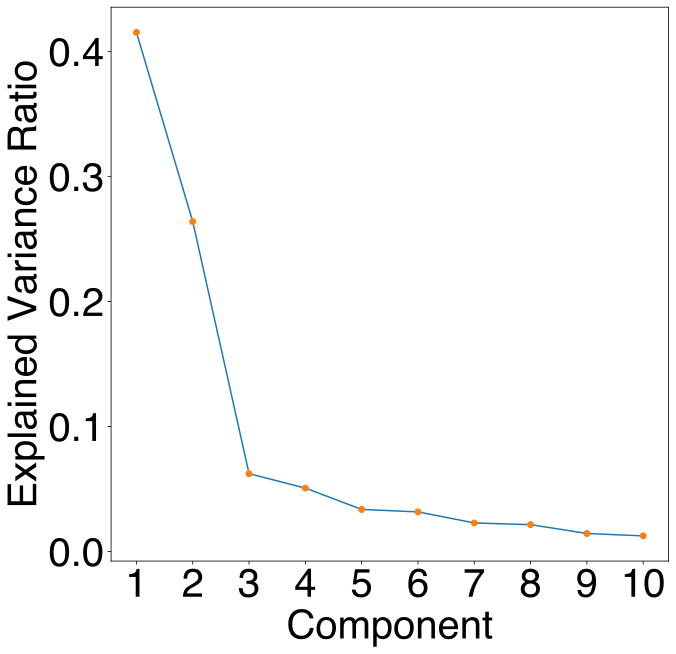

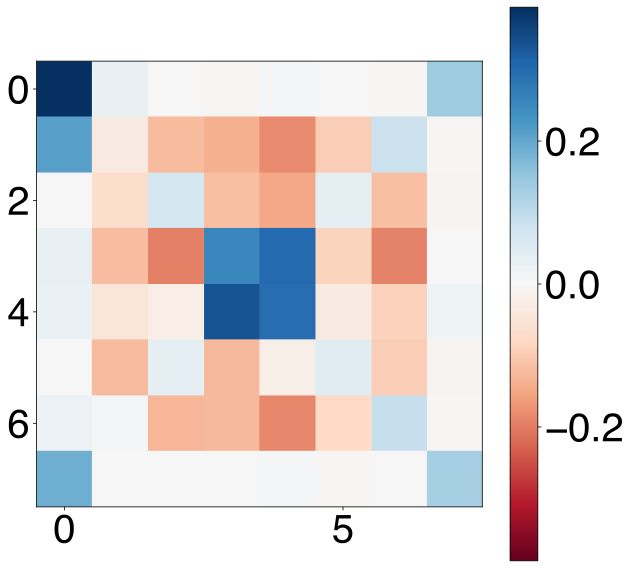

In [8]:
#pca on explorefreq
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca.fit(explorefreq) 

#scree plot
fig = plt.figure(figsize = (10,10))
plt.plot(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_, 'o')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
#set xtick labels
plt.xticks(range(0,10), [str(x) for x in range(1,11)])

#get first component loadings
loadings = pca.components_[3]
#reshape back into 8x8
loadings = loadings.reshape((8,8))
#plot
fig, ax = plt.subplots(figsize = (10,10))
#get rid of whitegrid
ax.grid(False)
#color map with white in the middle and red/blue at the extremes
plt.imshow(loadings, cmap = 'RdBu', vmin = -np.max(loadings), vmax = np.max(loadings))
plt.colorbar()

#get component scores
scores = pca.transform(explorefreq)
comp1 = scores[:,0]
df_part_free['explore_comp1'] = comp1
comp2 = scores[:,1]
df_part_free['explore_comp2'] = comp2
comp3 = scores[:,2]
df_part_free['explore_comp3'] = comp3

In [10]:
#variance explained by top 1
print(pca.explained_variance_ratio_[0])

#variance explained by top 2
print(pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[0])

#variance explained by top 3
print(pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[0])

0.415418730199559
0.679476628176232
0.7418387367014467


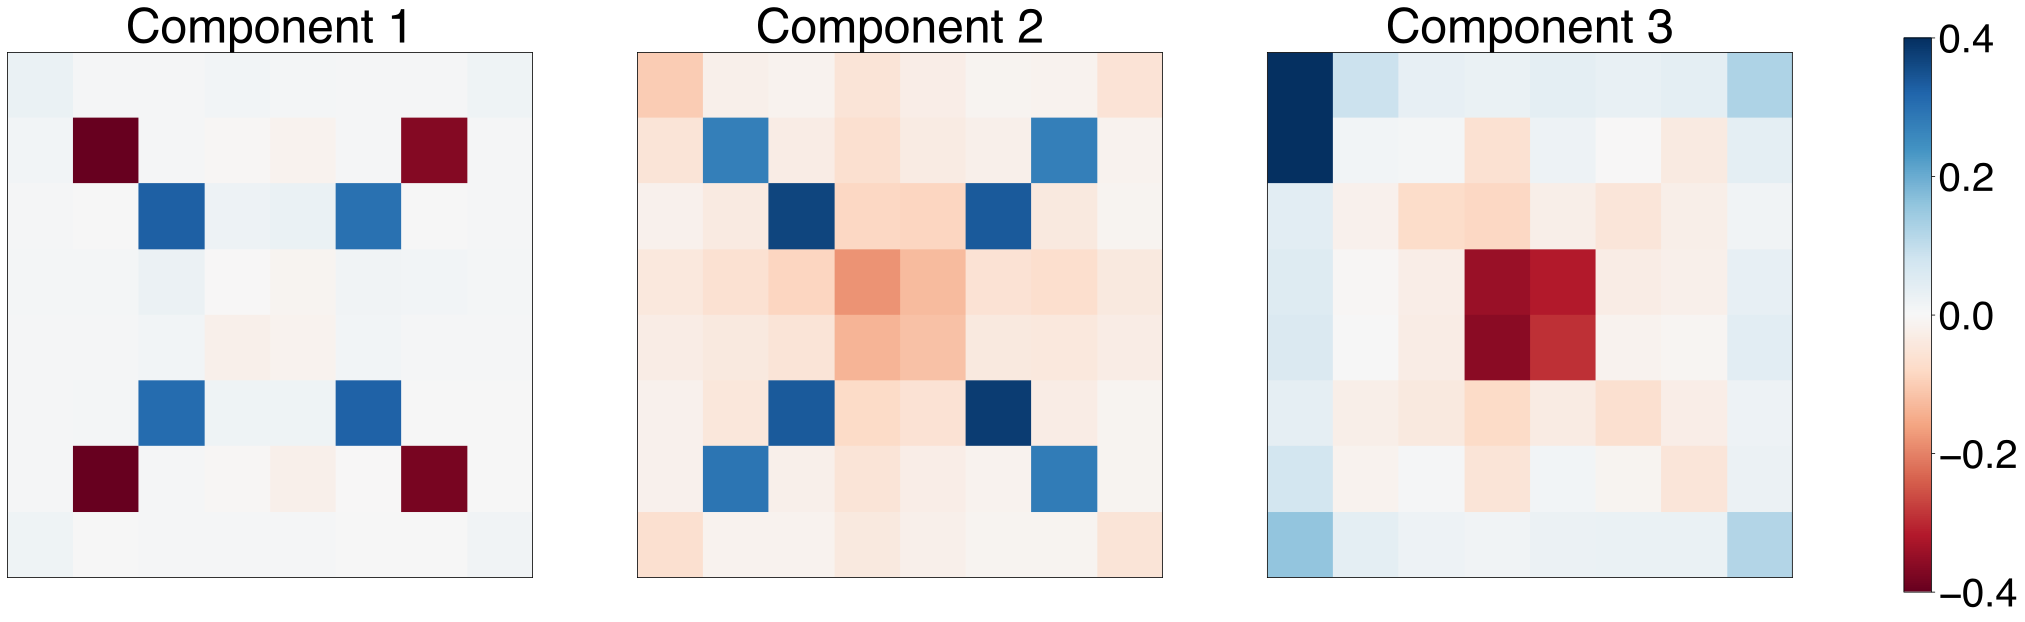

In [9]:

# imshow first 3 loadings on 8x8 grid
fig, ax = plt.subplots(1, 3, figsize=(40, 40))

loadings = pca.components_[0]
loadings = loadings.reshape((8, 8))
ax[0].grid(False)
vmin = -0.4
vmax = 0.4
im0 = ax[0].imshow(loadings, cmap='RdBu', vmin=vmin, vmax=vmax)
ax[0].set_title('Component 1')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])

loadings = pca.components_[1]
loadings = loadings.reshape((8, 8))
ax[1].grid(False)
im1 = ax[1].imshow(loadings, cmap='RdBu', vmin=vmin, vmax=vmax)
ax[1].set_title('Component 2')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticks([])
ax[1].set_yticks([])

loadings = pca.components_[2]
loadings = loadings.reshape((8, 8))
ax[2].grid(False)
im2 = ax[2].imshow(loadings, cmap='RdBu', vmin=vmin, vmax=vmax)
ax[2].set_title('Component 3')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# Set the same color scale for all subplots
fig.colorbar(im0, ax=ax, shrink=0.25)
# fig.colorbar(im1, ax=ax, shrink=0.25)
plt.show()


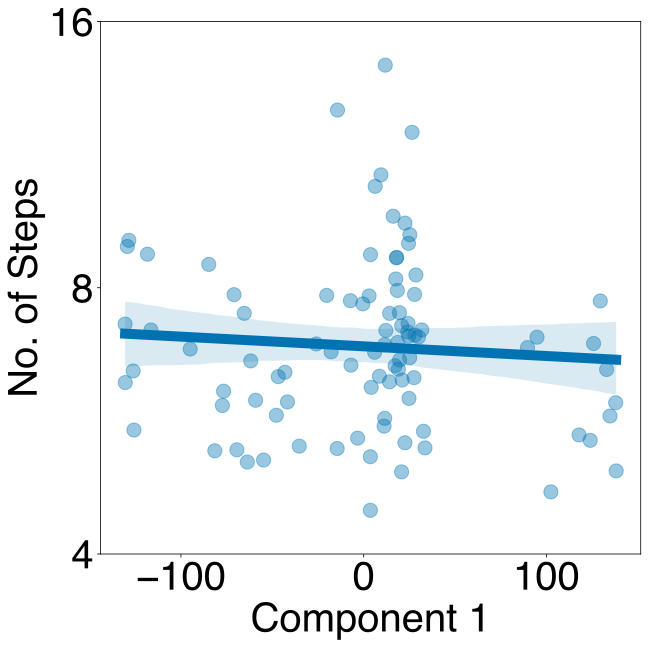

In [10]:
#subplots correlations bet components and logsteps

fig, ax = plt.subplots(1, figsize = (10, 10))
pal = sns.color_palette("colorblind")
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
pal.as_hex()
#get first color
col = pal[0]
sns.regplot(data = df_part_free, x = 'explore_comp1', y = 'resp_logsteps', line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, color = col)
plt.xlabel('Component 1')
plt.ylabel('No. of Steps')
plt.yticks([np.log(4), np.log(8), np.log(16)], ['4', '8', '16'])
#tight layout
plt.tight_layout()

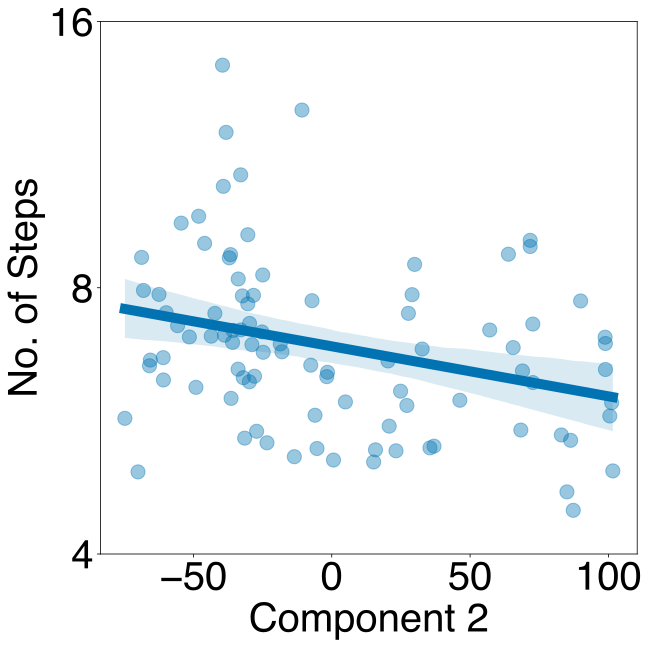

In [11]:
#subplots correlations bet components and logsteps

fig, ax = plt.subplots(1, figsize = (10, 10))
#xtick text size
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
pal = sns.color_palette("colorblind")
pal.as_hex()
#get first color
col = pal[0]
sns.regplot(data = df_part_free, x = 'explore_comp2', y = 'resp_logsteps', line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, color = col)
plt.xlabel('Component 2')
plt.ylabel('No. of Steps')
plt.yticks([np.log(4), np.log(8), np.log(16)], ['4', '8', '16'])
#tight layout
plt.tight_layout()

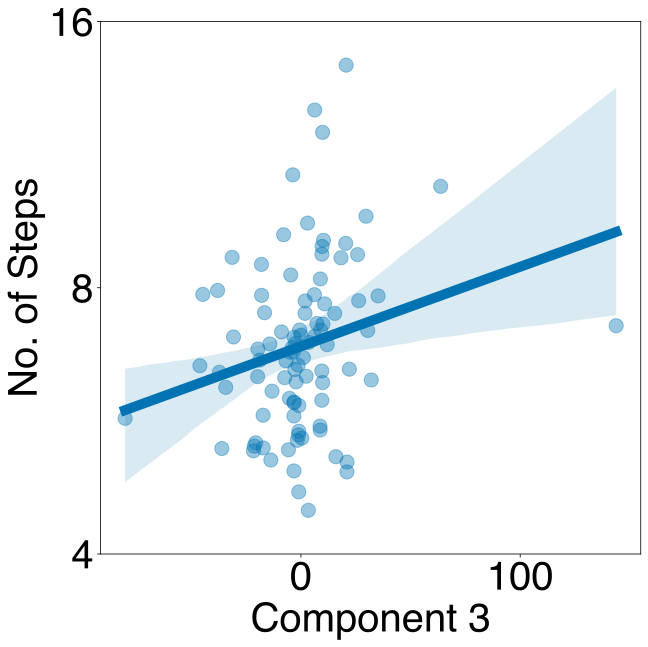

In [12]:
#subplots correlations bet components and logsteps

fig, ax = plt.subplots(1, figsize = (10, 10))
#xtick text size
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
pal = sns.color_palette("colorblind")
pal.as_hex()
#get first color
col = pal[0]
sns.regplot(data = df_part_free, x = 'explore_comp3', y = 'resp_logsteps', line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, color = col)
plt.xlabel('Component 3')
plt.ylabel('No. of Steps')
plt.yticks([np.log(4), np.log(8), np.log(16)], ['4', '8', '16'])
#tight layout
plt.tight_layout()

In [13]:
#lin regress exp components and logsteps
df_part_free = df_part_free.reset_index(drop = True)
df = df.reset_index(drop = True)
df_part_free['resp_logsteps_day2'] = [df[df['prolificid'] == x][df['day'] == 2]['resp_logsteps'].mean() for x in df_part_free['prolificid']]
df_part_free['resp_logsteps_day1'] = [df[df['prolificid'] == x][df['day'] == 1]['resp_logsteps'].mean() for x in df_part_free['prolificid']]
import statsmodels.api as sm
temp = df_part_free[['resp_logsteps_day2', 'explore_comp1', 'explore_comp2', 'explore_comp3', 'resp_logsteps_day1']]
temp['explore_comp1'] = (temp['explore_comp1'] - temp['explore_comp1'].mean())/temp['explore_comp1'].std()
temp['explore_comp2'] = (temp['explore_comp2'] - temp['explore_comp2'].mean())/temp['explore_comp2'].std()
temp['explore_comp3'] = (temp['explore_comp3'] - temp['explore_comp3'].mean())/temp['explore_comp3'].std()
sm.OLS.from_formula('resp_logsteps_day2 ~ resp_logsteps_day1 + explore_comp1 + explore_comp2 + explore_comp3', data = temp).fit().summary()

/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/89608164.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['resp_logsteps_day2'] = [df[df['prolificid'] == x][df['day'] == 2]['resp_logsteps'].mean() for x in df_part_free['prolificid']]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/89608164.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['resp_logsteps_day2'] = [df[df['prolificid'] == x][df['day'] == 2]['resp_logsteps'].mean() for x in df_part_free['prolificid']]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/89608164.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['resp_logsteps_day2'] = [df[df['prolificid'] == x][df['day'] == 2]['resp_logsteps'].mean() for x in df_part_free['prolificid']]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/89608164.py:4: UserWarning: Boolean Se

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/89608164.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['explore_comp1'] = (temp['explore_comp1'] - temp['explore_comp1'].mean())/temp['explore_comp1'].std()
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/89608164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['explore_comp2'] = (temp['explore_comp2'] - temp['explore_comp2'].mean())/temp['explore_comp2'].std()
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     resp_logsteps_day2   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     18.18
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           6.96e-11
Time:                        15:50:26   Log-Likelihood:                 27.829
No. Observations:                  92   AIC:                            -45.66
Df Residuals:                      87   BIC:                            -33.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8696      0.159      5.473      0.000       0.554       1.185
resp_logsteps_day1     0.4845      0.078      6.175      0.000       0.329       0.640
explore_comp1         -0.0103      0.019     -0.532      0.596      -0.049       0.028
explore_comp2         -0.0463      0.020     -2.332      0.022      -0.086      -0.007
explore_comp3          0.0728      0.019      3.761      0.000       0.034       0.111
==============================================================================
Omnibus:                        5.013   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                4.300
Skew:                           0.483   Prob(JB):                        0.117
Kurtosis:                       3.435   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
def calc_landmark_measures(gridlength, landmarks):

    # average distance to nearest landmark across whole grid
    grid = np.zeros((gridlength, gridlength), dtype=int)
    dists = []
    adj_to_landmark = 0
    for i in range(grid.shape[0]):
    # for i in range(1, grid.shape[0]-1):
        for j in range(grid.shape[1]):
        # for j in range(1, grid.shape[1]-1):
            # dists.append(min([np.linalg.norm(np.array([i, j]) - np.array(l)) for l in landmarks]))

            # calculate manhattan distance
            dists.append(min([abs(i - int(l[0])) + abs(j - int(l[1])) for l in landmarks]))
            if min([abs(i - int(l[0])) + abs(j - int(l[1])) for l in landmarks]) == 1:
                adj_to_landmark += 1
    avg_landmark_dist =  np.mean(dists)

    # standard deviation of distance to nearest landmark
    std_landmark_dist = np.std(dists)

    # average distance between all landmarks
    landmark_dists = []
    for i in range(len(landmarks)):
        for j in range(i+1, len(landmarks)):
            #use manhattan distance
            landmark_dists.append(abs(landmarks[i][0] - landmarks[j][0]) + abs(landmarks[i][1] - landmarks[j][1]))
    avg_landmark_dist_landmarks = np.mean(landmark_dists)

    # standard deviation of distance to nearest landmark
    std_landmark_dist_landmarks = np.std(landmark_dists)

    # average distance to all landmarks across whole grid
    grid = np.zeros((gridlength, gridlength), dtype=int)
    dists = []
    
    for i in range(grid.shape[0]):
    # for i in range(1, grid.shape[0]-1):
        for j in range(grid.shape[1]):
        # for j in range(1, grid.shape[1]-1):
            # dists.append(min([np.linalg.norm(np.array([i, j]) - np.array(l)) for l in landmarks]))

            # calculate manhattan distance
            dists.append(sum([abs(i - int(l[0])) + abs(j - int(l[1])) for l in landmarks]))

    avg_landmark_dist_all =  np.mean(dists)

    # distance to centre
    dists = []
    for l in landmarks:
        dists.append(abs(l[0] - (gridlength-1)/2) + abs(l[1] - (gridlength-1)/2))
    avg_landmark_dist_centre = np.mean(dists)

    # # convex hull
    # convex_hull = np.array(landmarks)
    # convex_hull = convex_hull[ConvexHull(convex_hull).vertices]
    # convex_hull_area = ConvexHull(convex_hull).area

    #average distance from each landmarks to all other states
    landmark_dists = []
    for i in range(len(landmarks)):
        for j in range(len(landmarks)):
            for x in range(gridlength):
                for y in range(gridlength):
                    landmark_dists.append(abs(x - int(landmarks[i][0]) + abs(y - int(landmarks[i][1]))))
    avg_landmark_dist_to_all = np.mean(landmark_dists)

    return avg_landmark_dist, std_landmark_dist, avg_landmark_dist_landmarks, std_landmark_dist_landmarks, avg_landmark_dist_all, adj_to_landmark, avg_landmark_dist_centre, avg_landmark_dist_to_all

In [20]:
#convert explorexclicks and exploreyclicks to strings
df['resp_explorexclicks'] = df['resp_explorexclicks'].astype(str)
df['resp_exploreyclicks'] = df['resp_exploreyclicks'].astype(str)
#  convert explorexclicks and exploreyclicks to a list of tuples, keeping only the unique tuples and dropping the last one
df['landmarks'] = [list(set(list(zip(x, y))[:-1])) for x, y in zip(df['resp_explorexclicks'], df['resp_exploreyclicks'])]

# minus one from all the tuples in landmarks
df['landmarks'] = [[(int(x[0])-1, int(x[1])-1) for x in l] for l in df['landmarks']]
#see result
df['landmarks']

0       [(4, 3), (4, 4), (1, 2), (3, 2), (2, 2), (5, 5...
1       [(4, 3), (5, 6), (4, 5), (1, 2), (2, 1), (6, 6...
2       [(1, 1), (4, 6), (4, 4), (3, 1), (2, 2), (2, 3...
3       [(1, 1), (5, 6), (2, 1), (5, 3), (2, 2), (2, 3...
4       [(5, 4), (5, 6), (1, 2), (3, 2), (6, 1), (3, 3...
                              ...                        
8875    [(5, 4), (3, 0), (0, 5), (5, 5), (7, 1), (6, 2...
8876    [(1, 0), (4, 4), (4, 6), (3, 0), (5, 6), (0, 3...
8877                                     [(3, 4), (2, 6)]
8878                     [(4, 2), (5, 5), (3, 1), (5, 1)]
8879    [(5, 4), (1, 0), (3, 0), (3, 2), (0, 4), (4, 7...
Name: landmarks, Length: 8880, dtype: object

In [21]:
gridlength = 8
df['avg_dist_to_landmark'], df['std_dist_to_landmark'], df['avg_dist_bet_landmarks'], df['std_dist_bet_landmarks'], df['all_dist_to_landmark'], df['adj_to_landmark'], df['avg_landmark_dist_to_centre'], df['avg_landmark_dist_to_all'] = zip(*[calc_landmark_measures(gridlength, l) for l in df['landmarks']])

In [16]:
#convert explorexclicks and exploreyclicks to strings
df_free['resp_explorexclicks'] = df_free['resp_explorexclicks'].astype(str)
df_free['resp_exploreyclicks'] = df_free['resp_exploreyclicks'].astype(str)
#  convert explorexclicks and exploreyclicks to a list of tuples, keeping only the unique tuples and dropping the last one
df_free['landmarks'] = [list(set(list(zip(x, y))[:-1])) for x, y in zip(df_free['resp_explorexclicks'], df_free['resp_exploreyclicks'])]

# minus one from all the tuples in landmarks
df_free['landmarks'] = [[(int(x[0])-1, int(x[1])-1) for x in l] for l in df_free['landmarks']]
#see result
df_free['landmarks']

0       [(1, 2), (2, 5), (2, 4), (6, 5), (4, 4), (5, 5...
1       [(1, 2), (1, 3), (4, 5), (6, 5), (1, 6), (2, 1...
2       [(6, 5), (4, 4), (3, 1), (4, 1), (3, 6), (2, 2...
3       [(2, 5), (2, 4), (2, 1), (6, 4), (2, 2), (5, 1...
4       [(1, 2), (2, 5), (2, 4), (1, 3), (6, 5), (5, 4...
                              ...                        
4411    [(3, 0), (2, 0), (3, 1), (0, 0), (0, 1), (4, 0...
4412    [(3, 0), (2, 0), (3, 1), (0, 0), (0, 1), (4, 0...
4413    [(3, 0), (2, 0), (3, 1), (0, 0), (0, 1), (4, 1...
4414    [(3, 0), (2, 0), (3, 1), (0, 0), (0, 1), (4, 0...
4415    [(3, 0), (2, 0), (3, 1), (0, 0), (0, 1), (4, 0...
Name: landmarks, Length: 4416, dtype: object

In [17]:
gridlength = 8
df_free['avg_dist_to_landmark'], df_free['std_dist_to_landmark'], df_free['avg_dist_bet_landmarks'], df_free['std_dist_bet_landmarks'], df_free['all_dist_to_landmark'], df_free['adj_to_landmark'], df_free['avg_landmark_dist_to_centre'], df_free['avg_landmark_dist_to_all'] = zip(*[calc_landmark_measures(gridlength, l) for l in df_free['landmarks']])

In [18]:
#move landmark measures to df_part_free using merge on
df_part_free = df_part[df_part['condition'] == 'free']
temp = df_free[df_free['cond_freeorforced'] == 0].groupby('prolificid')[['avg_dist_to_landmark', 'std_dist_to_landmark', 'avg_dist_bet_landmarks', 'std_dist_bet_landmarks', 'all_dist_to_landmark', 'adj_to_landmark', 'avg_landmark_dist_to_centre', 'avg_landmark_dist_to_all']].mean().reset_index()
df_part_free = pd.merge(df_part_free, temp[['prolificid', 'avg_dist_to_landmark', 'std_dist_to_landmark', 'avg_dist_bet_landmarks', 'std_dist_bet_landmarks', 'all_dist_to_landmark', 'adj_to_landmark', 'avg_landmark_dist_to_centre', 'avg_landmark_dist_to_all']], on = 'prolificid')
df_part_free['numuniqueclicks_free'] = df_free[df_free['cond_freeorforced'] == 0].groupby('prolificid')['resp_numuniqueclicks'].mean().values

In [38]:
df_probe_free = df_probe[df_probe['condition'] == 'free']
df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
df_part_free['avggoalerror_free'] = [df_probe_free[df_probe_free['goal'] == 1][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
df_part_free['avglandmarkerror_forced'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 1][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]

/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1569761595.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1569761595.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1569761595.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 

/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/3606760743.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g2 = sns.swarmplot(data = temp, x = 'condition', y = 'avg_dist_to_landmark', palette = 'colorblind', size = 18, alpha = 0.5)


([<matplotlib.axis.XTick at 0x13f298c90>], [Text(0, 0, 'Free')])

<Figure size 1000x1000 with 0 Axes>

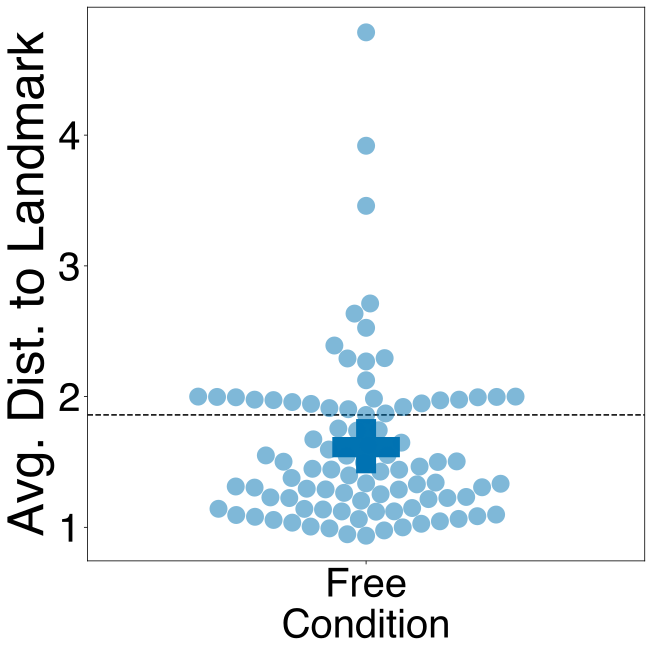

In [39]:
#plot
fig = plt.figure(figsize = (10,10))
# %% performance free vs forced
        
temp = df_part_free
fig = plt.figure(figsize = (10,10))
g = sns.pointplot(data = temp, y = 'avg_dist_to_landmark', linestyles = 'none', markers = '_', scale = 10, errwidth = 20, palette = 'colorblind')

#xtick

# # plt.yticks([np.log(4), np.log(8), np.log(16), np.log(32)], ['4', '8', '16', '32'])

# #add swarmplot
g2 = sns.swarmplot(data = temp, x = 'condition', y = 'avg_dist_to_landmark', palette = 'colorblind', size = 18, alpha = 0.5)
#add dotted line at y = 1.86
plt.axhline(y = 1.86, color = 'black', linestyle = '--')
plt.ylabel('Avg. Dist. to Landmark', fontsize = 50)
plt.xlabel('Condition') 
# plt.ylabel('Error on Probe Trials')
plt.xticks([0], ['Free'])


/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1239452674.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g2 = sns.swarmplot(data = temp, x = 'condition', y = 'avg_landmark_dist_to_centre', palette = 'colorblind', size = 18, alpha = 0.5)


([<matplotlib.axis.XTick at 0x135d3e950>], [Text(0, 0, 'Free')])

<Figure size 1000x1000 with 0 Axes>

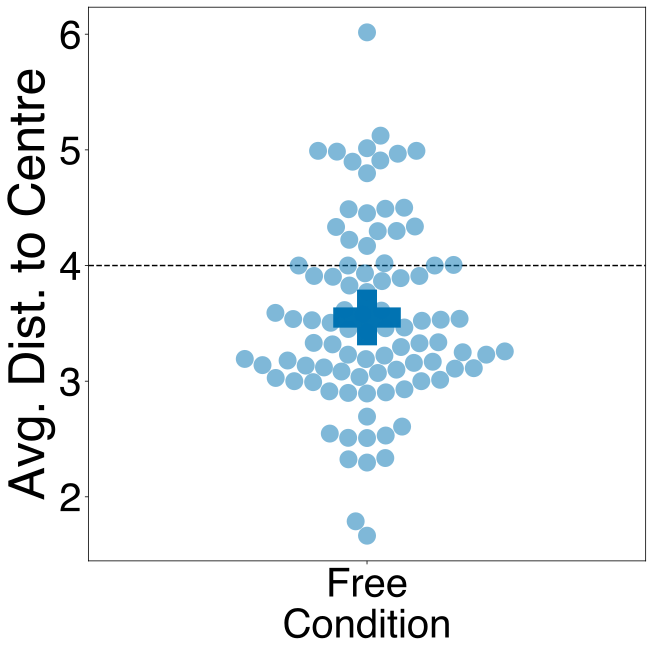

In [21]:
#plot
fig = plt.figure(figsize = (10,10))
# %% performance free vs forced
        
temp = df_part_free
fig = plt.figure(figsize = (10,10))
g = sns.pointplot(data = temp, y = 'avg_landmark_dist_to_centre', linestyles = 'none', markers = '_', scale = 10, errwidth = 20, palette = 'colorblind')

#xtick

# # plt.yticks([np.log(4), np.log(8), np.log(16), np.log(32)], ['4', '8', '16', '32'])

# #add swarmplot
g2 = sns.swarmplot(data = temp, x = 'condition', y = 'avg_landmark_dist_to_centre', palette = 'colorblind', size = 18, alpha = 0.5)
#add dotted line at y = 1.86
plt.axhline(y = 4, color = 'black', linestyle = '--')
plt.ylabel('Avg. Dist. to Centre', fontsize = 50)
plt.xlabel('Condition')
# plt.ylabel('Error on Probe Trials')
plt.xticks([0], ['Free'])


In [24]:
df_probe

,Unnamed: 0,partno,correctx,correcty,respx,respy,goal,error,goalx,goaly,freeorforced,numlandmarks,numuniqueclicks,logsteps,numexposures,trialno,errorx,errory
0,0,A6UJ41,4,4,4,4,0,0.000000,7,2,1,8,8,1.792,2,1,0,0
1,1,A6UJ41,7,2,6,3,1,1.414214,7,2,1,8,8,1.792,1,1,1,1
2,2,A6UJ41,2,6,3,6,0,1.000000,7,2,1,8,8,1.792,2,1,1,0
3,3,M2HVS3,5,7,5,7,1,0.000000,5,7,1,4,4,1.792,1,1,0,0
4,4,M2HVS3,3,3,3,3,0,0.000000,5,7,1,4,4,1.792,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8875,4459,I3KVB5,4,7,5,6,0,1.414214,5,5,1,16,16,2.484,1,24,1,1
8876,4460,I3KVB5,5,5,5,5,1,0.000000,5,5,1,16,16,2.484,1,24,0,0
8877,4461,78O30N,2,7,2,7,1,0.000000,2,7,1,12,12,1.792,1,24,0,0
8878,4462,78O30N,6,4,5,4,0,1.000000,2,7,1,12,12,1.792,2,24,1,0


/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1741925634.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g2 = sns.swarmplot(data = temp, x = 'condition', y = 'error', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])


([<matplotlib.axis.XTick at 0x135d22bd0>,
 [Text(0.0, 0, 'Free'), Text(1.0, 0, 'Forced')])

/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 1000x1000 with 0 Axes>

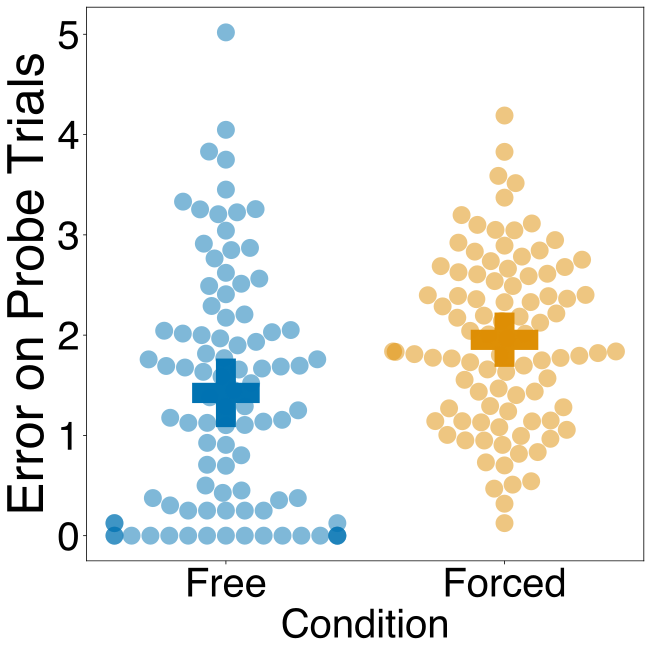

In [26]:
#plot
fig = plt.figure(figsize = (10,10))
# %% performance free vs forced
        
temp = df_probe[(df_probe['day'] == 2) & (df_probe['goal'] == 0)].groupby(['partno', 'condition'])['error'].mean().reset_index()

fig = plt.figure(figsize = (10,10))
g = sns.pointplot(data = temp, x = 'condition', y = 'error', linestyles = 'none', markers = '_', scale = 10, errwidth = 20, palette = 'colorblind', order = ['free', 'forced'])

#xtick

# plt.yticks([np.log(4), np.log(8), np.log(16), np.log(32)], ['4', '8', '16', '32'])

#add swarmplot
g2 = sns.swarmplot(data = temp, x = 'condition', y = 'error', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])
plt.xlabel('Condition')
plt.ylabel('Error on Probe Trials', fontsize = 50)
plt.xticks(np.linspace(0,1, 2), ['Free', 'Forced'])


In [28]:
#corr performance and landmark metrics
model = sm.OLS.from_formula('resp_logsteps_free ~ resp_logsteps_forced + avglandmarkerror_free + avg_dist_to_landmark + avg_landmark_dist_to_centre', data = df_part_free)
results = model.fit()
results.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     resp_logsteps_free   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     29.69
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           1.42e-15
Time:                        15:53:46   Log-Likelihood:                 39.486
No. Observations:                  92   AIC:                            -68.97
Df Residuals:                      87   BIC:                            -56.36
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.4554      0.154      2.954      0.004       0.149       0.762
resp_logsteps_forced            0.4245      0.069      6.109      0.000       0.286       0.563
avglandmarkerror_free           0.1039      0.017      6.130      0.000       0.070       0.138
avg_dist_to_landmark            0.0754      0.031      2.436      0.017       0.014       0.137
avg_landmark_dist_to_centre     0.0689      0.022      3.069      0.003       0.024       0.113
==============================================================================
Omnibus:                       12.612   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.931
Skew:                           0.589   Prob(JB):                     7.75e-05
Kurtosis:                       4.884   Cond. No.                         47.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
import statsmodels.api as sm
#corr explore comp 2
model = sm.OLS.from_formula('avg_dist_to_landmark ~ numuniqueclicks + explore_comp1 + explore_comp2 + explore_comp3', data = df_part_free)
results = model.fit()
results.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     avg_dist_to_landmark   R-squared:                       0.742
Model:                              OLS   Adj. R-squared:                  0.730
Method:                   Least Squares   F-statistic:                     62.65
Date:                  Mon, 07 Oct 2024   Prob (F-statistic):           8.05e-25
Time:                          15:54:11   Log-Likelihood:                -24.845
No. Observations:                    92   AIC:                             59.69
Df Residuals:                        87   BIC:                             72.30
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1358      0.185     22.394      0.000       3.769       4.503
numuniqueclicks    -0.2793      0.020    -13.894      0.000      -0.319      -0.239
explore_comp1       0.0017      0.001      3.295      0.001       0.001       0.003
explore_comp2      -0.0068      0.001     -7.775      0.000      -0.009      -0.005
explore_comp3       0.0104      0.001      7.650      0.000       0.008       0.013
==============================================================================
Omnibus:                       13.562   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.706
Skew:                           0.680   Prob(JB):                     8.67e-05
Kurtosis:                       4.741   Cond. No.                         353.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
import statsmodels.api as sm
#corr explore comp 2
model = sm.OLS.from_formula('avg_landmark_dist_to_centre ~  explore_comp1 + explore_comp2 + explore_comp3', data = df_part_free)
results = model.fit()
results.summary()

#SEs are too small to be displayed in the table, print out the SEs separately
# results.bse

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     avg_landmark_dist_to_centre   R-squared:                       0.880
Model:                                     OLS   Adj. R-squared:                  0.876
Method:                          Least Squares   F-statistic:                     215.9
Date:                         Mon, 07 Oct 2024   Prob (F-statistic):           1.87e-40
Time:                                 15:54:14   Log-Likelihood:                -10.542
No. Observations:                           92   AIC:                             29.08
Df Residuals:                               88   BIC:                             39.17
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.5503      0.029    122.739      0.000       3.493       3.608
explore_comp1    -0.0055      0.000    -12.371      0.000      -0.006      -0.005
explore_comp2     0.0036      0.001      6.356      0.000       0.002       0.005
explore_comp3     0.0246      0.001     21.314      0.000       0.022       0.027
==============================================================================
Omnibus:                        7.190   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                9.176
Skew:                          -0.355   Prob(JB):                       0.0102
Kurtosis:                       4.374   Cond. No.                         64.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
df_part_free['avggoalerror_free'] = [df_probe_free[df_probe_free['goal'] == 1][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
df_part_free['avglandmarkerror_forced'] = [df_probe[df_probe['goal'] == 0][df_probe['freeorforced'] == 1][df_probe['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]

/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/4235194927.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/4235194927.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 0][df_probe_free['partno'] == x]['error'].mean() for x in df_part_free['prolificid']]
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/4235194927.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part_free['avglandmarkerror_free'] = [df_probe_free[df_probe_free['goal'] == 0][df_probe_free['freeorforced'] == 

In [47]:
import statsmodels.api as sm
#corr explore comp 2
model = sm.OLS.from_formula('avglandmarkerror_free ~ avglandmarkerror_forced + numuniqueclicks + explore_comp1 + explore_comp2 + explore_comp3', data = df_part_free)
results = model.fit()
results.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     avglandmarkerror_free   R-squared:                       0.619
Model:                               OLS   Adj. R-squared:                  0.597
Method:                    Least Squares   F-statistic:                     27.96
Date:                   Mon, 07 Oct 2024   Prob (F-statistic):           1.04e-16
Time:                           15:58:44   Log-Likelihood:                -97.982
No. Observations:                     92   AIC:                             208.0
Df Residuals:                         86   BIC:                             223.1
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.8239      0.281     -2.928      0.004      -1.383      -0.264
avglandmarkerror_forced     0.6486      0.131      4.948      0.000       0.388       0.909
numuniqueclicks             0.1521      0.023      6.716      0.000       0.107       0.197
explore_comp1              -0.0005      0.001     -0.453      0.652      -0.003       0.002
explore_comp2               0.0001      0.002      0.054      0.957      -0.004       0.004
explore_comp3               0.0017      0.003      0.552      0.583      -0.004       0.008
==============================================================================
Omnibus:                       25.022   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.128
Skew:                           0.982   Prob(JB):                     1.76e-12
Kurtosis:                       6.203   Cond. No.                         249.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
df_part_free['numuniqueclicks'] = df_part_free['numuniqueclicks'] * 2 - 8
df_part_free['numuniqueclicks'].value_counts()

numuniqueclicks
15.166667    5
14.583333    3
3.541667     3
15.333333    3
7.458333     2
            ..
10.625000    1
13.958333    1
13.166667    1
8.000000     1
7.500000     1
Name: count, Length: 70, dtype: int64

/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1462732950.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[i, j].scatter([], [], c = colors[0], label = 'Low Num. Landmarks', s = 200, alpha = 0.6)
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28043/1462732950.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[i, j].scatter([], [], c = colors[1], label = 'High Num. Landmarks', s = 200

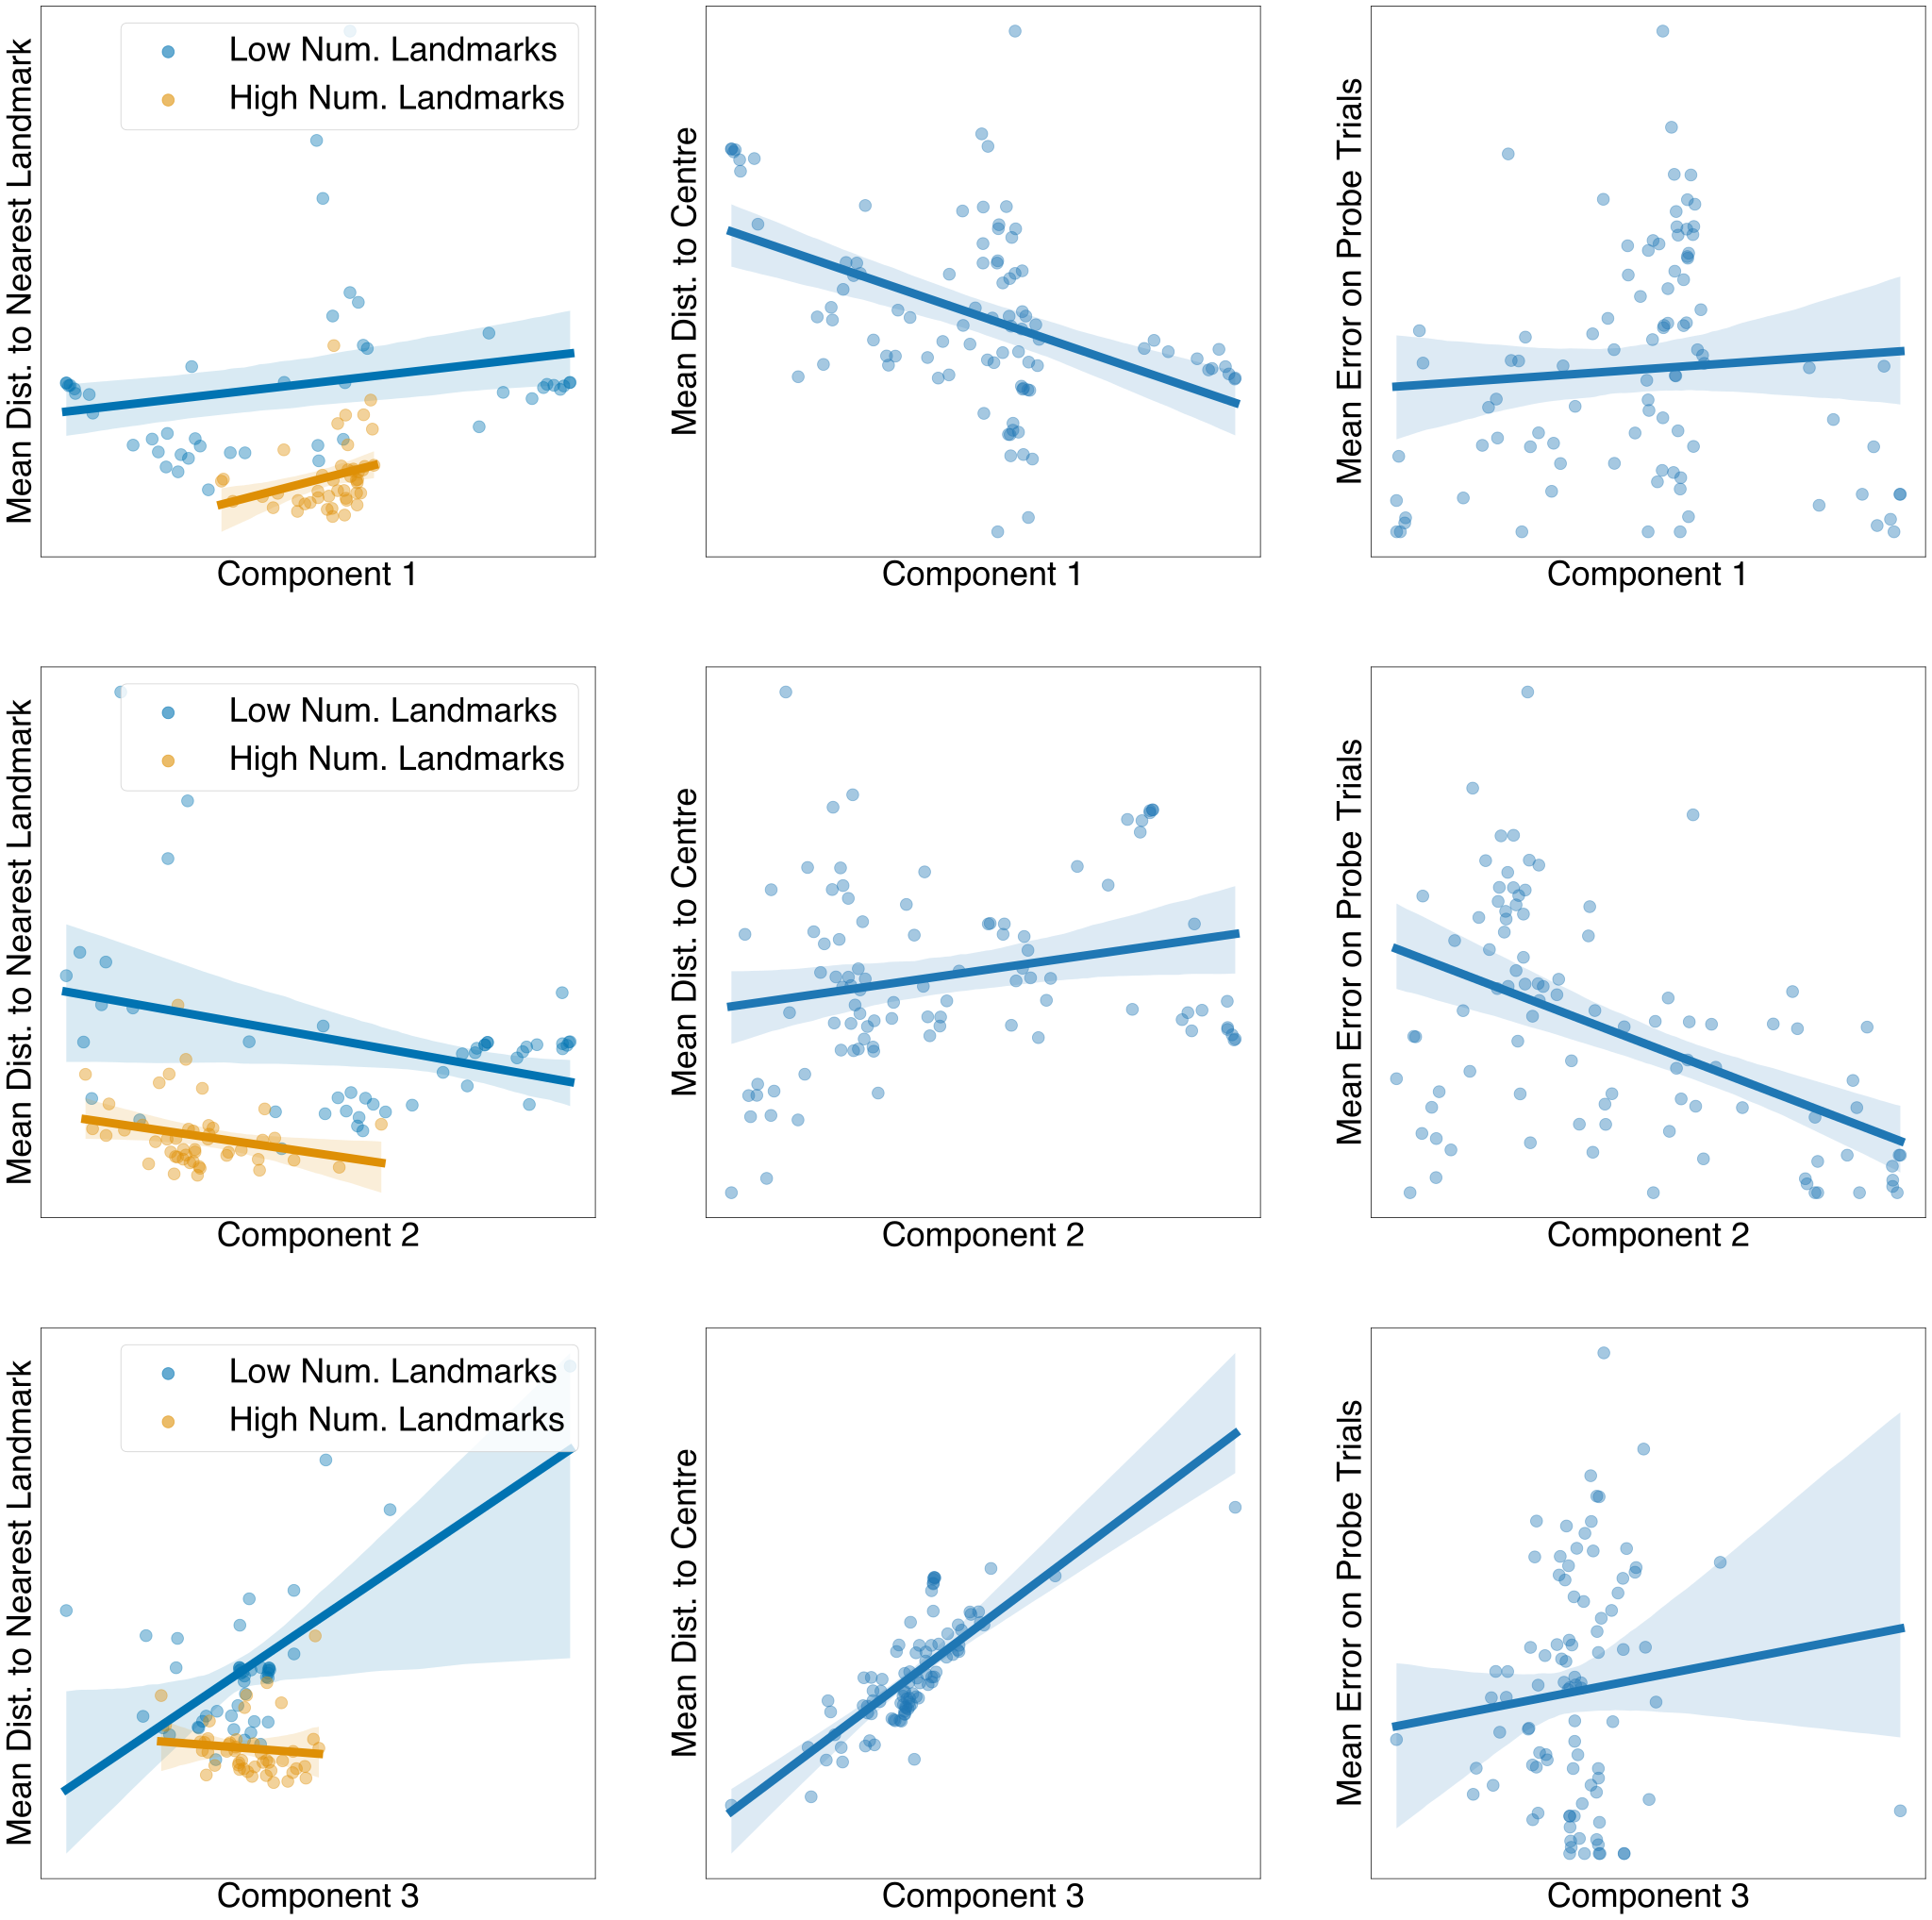

In [48]:
#regplots on a facetgrid; x is component 1, 2, and 3, y is avg_dist_to_landmark, avg_landmark_dist_to_centre and avglandmarkerror_free

#subplots correlations bet components and logsteps

xfields = ['explore_comp1', 'explore_comp2', 'explore_comp3']
xtitles = ['Component 1', 'Component 2', 'Component 3']
yfields = ['avg_dist_to_landmark', 'avg_landmark_dist_to_centre', 'avglandmarkerror_free']
ytitles = ['Mean Dist. to Nearest Landmark', 'Mean Dist. to Centre', 'Mean Error on Probe Trials']

fig, ax = plt.subplots(3, 3, figsize = (40, 40))

for i, xfield in enumerate(xfields):
    for j, yfield in enumerate(yfields):
        if yfield == 'avg_dist_to_landmark':
        # if True:
            #median split by numuniqueclicks
            df_part_free['numuniqueclicks_median'] = pd.qcut(df_part_free['numuniqueclicks'], 2, labels = False)
            colors = list(sns.color_palette("colorblind"))

            hue_regplot(data = df_part_free, x = xfield, y = yfield, line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, ax = ax[i, j], hue = 'numuniqueclicks_median', palette = colors)
            #legend
            #fake plot for legend
            colors = sns.color_palette("colorblind")
            ax[i, j].scatter([], [], c = colors[0], label = 'Low Num. Landmarks', s = 200, alpha = 0.6)
            ax[i, j].scatter([], [], c = colors[1], label = 'High Num. Landmarks', s = 200, alpha = 0.6)
            ax[i, j].legend(loc = 'upper right', fontsize = 40)
        else:
            sns.regplot(data = df_part_free, x = xfield, y = yfield, line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, ax = ax[i, j])
        # sns.scatterplot(data = df_part_free, x = xfield, y = yfield, ax = ax[i, j], hue = 'numuniqueclicks', s = 200)
        ax[i, j].set_xlabel(xtitles[i])
        ax[i, j].set_ylabel(ytitles[j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

In [15]:
#load
df_model = pd.read_hdf('data/df_model_freeandforced.h5', key = 'df')
df_trials = pd.read_hdf('data/df_model_trials_freeandforced.h5', key = 'df')

/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28491/3976451901.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g2 = sns.swarmplot(data = temp, x = 'condition', y = 'logsteps', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])


Text(55.597222222222214, 0.5, 'No. of Steps')

/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


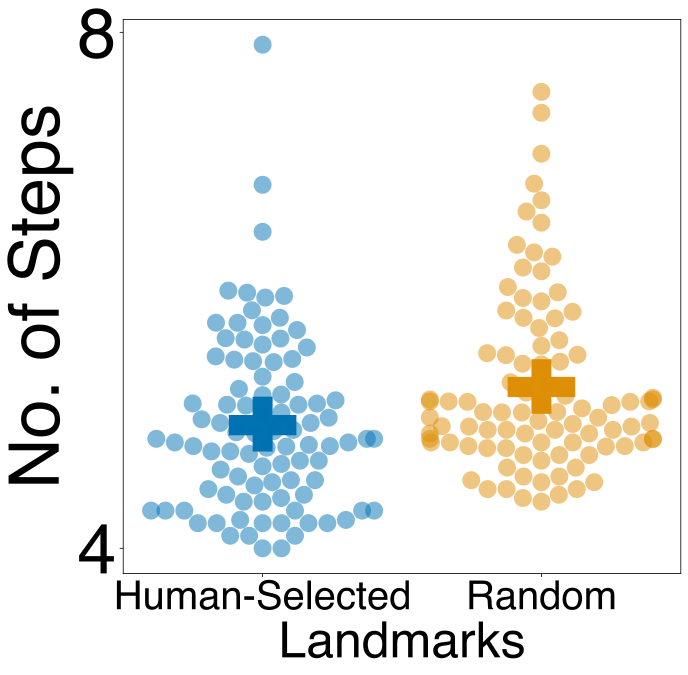

In [16]:
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 40
# inds = [(np.max(df_trials['landmarkxs'][i]) < 7) & (np.max(df_trials['landmarkys'][i]) < 7) & (np.min(df_trials['landmarkxs'][i]) > 0) & (np.min(df_trials['landmarkys'][i]) > 0) for i in range(len(df_trials))]
temp = df_trials[df_trials['day'] == 2].groupby(['partno', 'condition'])['logsteps'].mean().reset_index()
fig = plt.figure(figsize = (10,10))
g = sns.pointplot(data = temp, x = 'condition', y = 'logsteps', linestyles = 'none', markers = '_', scale = 10, errwidth = 20, palette = 'colorblind', order = ['free', 'forced'])
plt.xlabel('Condition')
plt.ylabel('No. of Steps')
#xtick

plt.yticks([np.log(4), np.log(8)], ['4','8'], fontsize = 70)

#add swarmplot
g2 = sns.swarmplot(data = temp, x = 'condition', y = 'logsteps', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])

plt.xticks(np.linspace(0,1, 2), ['Human-Selected', 'Random'])
plt.xlabel('Landmarks', fontsize = 50)
plt.ylabel('No. of Steps', fontsize = 70)

/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/var/folders/0y/gjx_6j1j6b74t37j8v49ws6m0000gs/T/ipykernel_28491/3976451901.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g2 = sns.swarmplot(data = temp, x = 'condition', y = 'logsteps', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])


Text(55.597222222222214, 0.5, 'No. of Steps')

/Users/denislan/opt/anaconda3/envs/dl/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


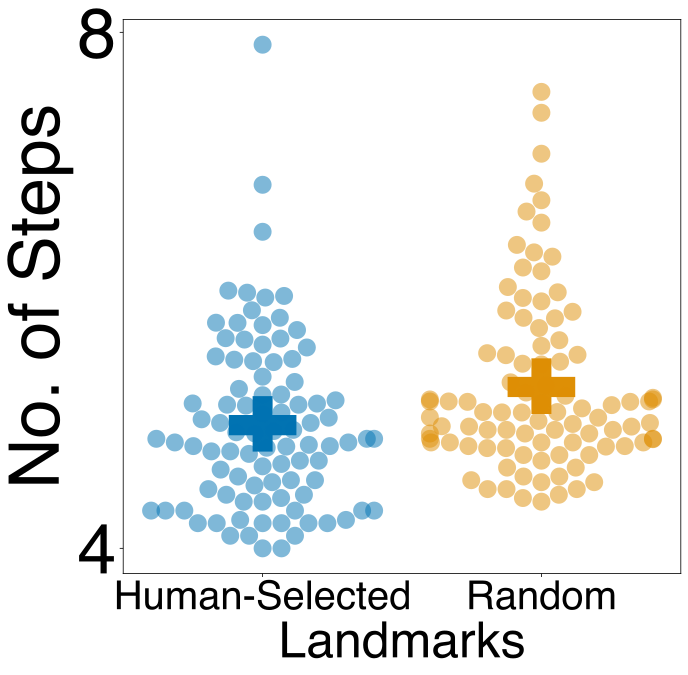

In [17]:
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 40
# inds = [(np.max(df_trials['landmarkxs'][i]) < 7) & (np.max(df_trials['landmarkys'][i]) < 7) & (np.min(df_trials['landmarkxs'][i]) > 0) & (np.min(df_trials['landmarkys'][i]) > 0) for i in range(len(df_trials))]
temp = df_trials[df_trials['day'] == 2].groupby(['partno', 'condition'])['logsteps'].mean().reset_index()
fig = plt.figure(figsize = (10,10))
g = sns.pointplot(data = temp, x = 'condition', y = 'logsteps', linestyles = 'none', markers = '_', scale = 10, errwidth = 20, palette = 'colorblind', order = ['free', 'forced'])
plt.xlabel('Condition')
plt.ylabel('No. of Steps')
#xtick

plt.yticks([np.log(4), np.log(8)], ['4','8'], fontsize = 70)

#add swarmplot
g2 = sns.swarmplot(data = temp, x = 'condition', y = 'logsteps', palette = 'colorblind', size = 18, alpha = 0.5, order = ['free', 'forced'])

plt.xticks(np.linspace(0,1, 2), ['Human-Selected', 'Random'])
plt.xlabel('Landmarks', fontsize = 50)
plt.ylabel('No. of Steps', fontsize = 70)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logsteps   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     10.27
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           7.27e-06
Time:                        16:12:20   Log-Likelihood:                 81.422
No. Observations:                  92   AIC:                            -154.8
Df Residuals:                      88   BIC:                            -144.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5518      0.011    145.773      0.000       1.531       1.573
explore_comp1    -0.0433      0.011     -4.044      0.000      -0.065      -0.022
explore_comp2    -0.0224      0.011     -2.089      0.040      -0.044      -0.001
explore_comp3     0.0340      0.011      3.176      0.002       0.013       0.055
==============================================================================
Omnibus:                       22.417   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.273
Skew:                           1.054   Prob(JB):                     3.61e-08
Kurtosis:                       5.121   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

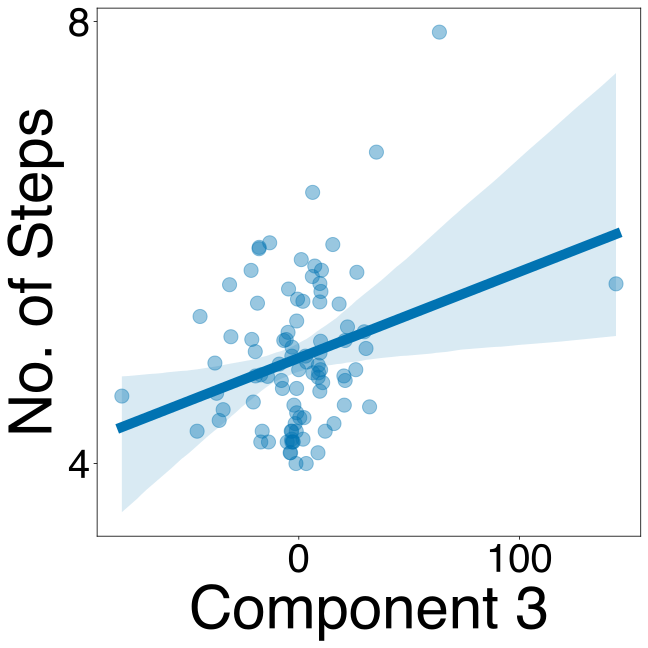

In [18]:
temp = df_trials[(df_trials['condition'] == 'free') & (df_trials['day'] == 2)].groupby(['partno'])['logsteps'].mean().reset_index()
temp['explore_comp1'] = [df_part['explore_comp1'][df_part['prolificid'] == x].values[0] for x in temp['partno']]
temp['explore_comp2'] = [df_part['explore_comp2'][df_part['prolificid'] == x].values[0] for x in temp['partno']]
temp['explore_comp3'] = [df_part['explore_comp3'][df_part['prolificid'] == x].values[0] for x in temp['partno']]


pal = sns.color_palette("colorblind")

pal.as_hex()
#get first color
col = pal[0]
fig = plt.figure(figsize = (10, 10))
g = sns.regplot(x = 'explore_comp3', y = 'logsteps', data = temp, line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, color = col)
# sns.regplot(data = df_part_free, x = 'explore_comp1', y = 'resp_logsteps'
plt.xlabel('Component 3', fontsize = 60)
plt.ylabel('No. of Steps', fontsize = 60)
plt.yticks([np.log(4), np.log(8)], ['4', '8'])
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
#tight layout
plt.tight_layout()
# #lin reg
import statsmodels.api as sm
temp['explore_comp1'] = (temp['explore_comp1'] - temp['explore_comp1'].mean())/temp['explore_comp1'].std()
temp['explore_comp2'] = (temp['explore_comp2'] - temp['explore_comp2'].mean())/temp['explore_comp2'].std()
temp['explore_comp3'] = (temp['explore_comp3'] - temp['explore_comp3'].mean())/temp['explore_comp3'].std()
X = temp[['explore_comp1', 'explore_comp2', 'explore_comp3']]
Y = temp['logsteps']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logsteps   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     10.27
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           7.27e-06
Time:                        16:12:25   Log-Likelihood:                 81.422
No. Observations:                  92   AIC:                            -154.8
Df Residuals:                      88   BIC:                            -144.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5518      0.011    145.773      0.000       1.531       1.573
explore_comp1    -0.0433      0.011     -4.044      0.000      -0.065      -0.022
explore_comp2    -0.0224      0.011     -2.089      0.040      -0.044      -0.001
explore_comp3     0.0340      0.011      3.176      0.002       0.013       0.055
==============================================================================
Omnibus:                       22.417   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.273
Skew:                           1.054   Prob(JB):                     3.61e-08
Kurtosis:                       5.121   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

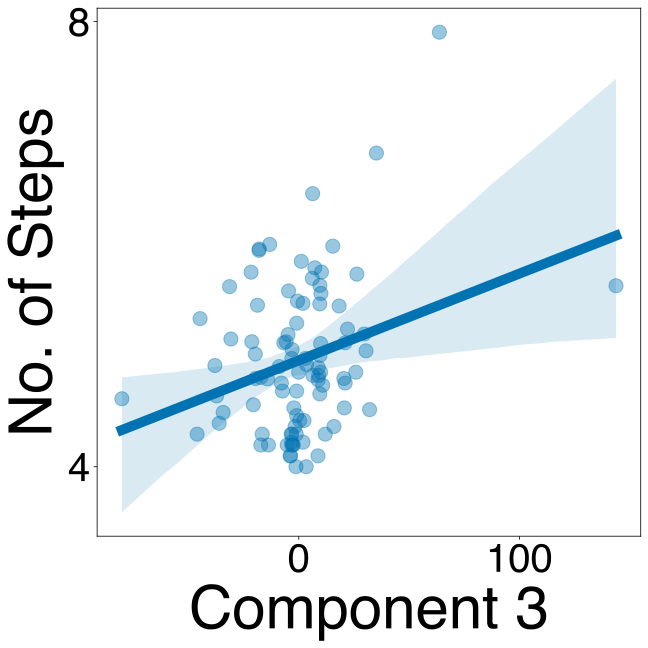

In [19]:
temp = df_trials[(df_trials['condition'] == 'free') & (df_trials['day'] == 2)].groupby(['partno'])['logsteps'].mean().reset_index()
temp['explore_comp1'] = [df_part['explore_comp1'][df_part['prolificid'] == x].values[0] for x in temp['partno']]
temp['explore_comp2'] = [df_part['explore_comp2'][df_part['prolificid'] == x].values[0] for x in temp['partno']]
temp['explore_comp3'] = [df_part['explore_comp3'][df_part['prolificid'] == x].values[0] for x in temp['partno']]


pal = sns.color_palette("colorblind")

pal.as_hex()
#get first color
col = pal[0]
fig = plt.figure(figsize = (10, 10))
g = sns.regplot(x = 'explore_comp3', y = 'logsteps', data = temp, line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, color = col)
# sns.regplot(data = df_part_free, x = 'explore_comp1', y = 'resp_logsteps'
plt.xlabel('Component 3', fontsize = 60)
plt.ylabel('No. of Steps', fontsize = 60)
plt.yticks([np.log(4), np.log(8)], ['4', '8'])
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
#tight layout
plt.tight_layout()
# #lin reg
import statsmodels.api as sm
temp['explore_comp1'] = (temp['explore_comp1'] - temp['explore_comp1'].mean())/temp['explore_comp1'].std()
temp['explore_comp2'] = (temp['explore_comp2'] - temp['explore_comp2'].mean())/temp['explore_comp2'].std()
temp['explore_comp3'] = (temp['explore_comp3'] - temp['explore_comp3'].mean())/temp['explore_comp3'].std()
X = temp[['explore_comp1', 'explore_comp2', 'explore_comp3']]
Y = temp['logsteps']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logsteps   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     19.97
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           2.28e-05
Time:                        16:14:17   Log-Likelihood:                 76.832
No. Observations:                  92   AIC:                            -149.7
Df Residuals:                      90   BIC:                            -144.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1184      0.098     11.459      0.000       0.925       1.312
part_logsteps     0.2249      0.050      4.469      0.000       0.125       0.325
==============================================================================
Omnibus:                       16.331   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.200
Skew:                           0.779   Prob(JB):                     5.56e-06
Kurtosis:                       4.971   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

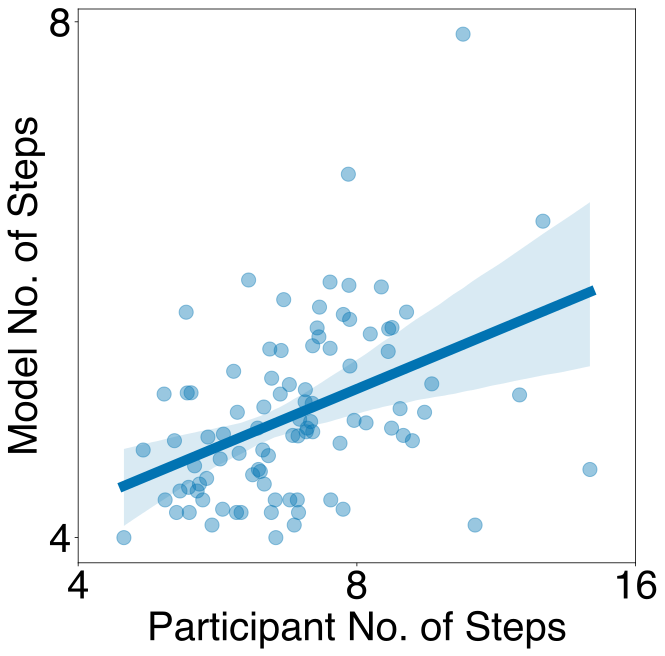

In [23]:
temp['part_logsteps'] = [df_part_free['resp_logsteps'][df_part_free['prolificid'] == x].values[0] for x in temp['partno']]

#scatter model and part logsteps
fig = plt.figure(figsize = (10,10))
g = sns.regplot(x = 'part_logsteps', y = 'logsteps', data = temp, line_kws = {'linewidth': 10, 'alpha': 1}, scatter_kws = {'s': 200, 'alpha': 0.4}, color = col)
g.set(xlabel = 'Participant No. of Steps', ylabel = 'Model No. of Steps')
plt.xticks([np.log(4), np.log(8), np.log(16)], ['4', '8', '16'])
plt.yticks([np.log(4), np.log(8)], ['4', '8'])
# #identitiy line
# plt.plot([np.log(4), np.log(8)], [np.log(4), np.log(8)], 'k--')
#stats
X = temp['part_logsteps']
Y = temp['logsteps']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()
